## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
%%capture
! pip install -r requirements.txt

In [3]:
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf
from pathlib import Path
import csv

/usr/local/lib/python3.8/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [12]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [6]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [7]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",period=15,starting_date = '1 Mar 2017')

In [8]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [9]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (192936, 8)


In [13]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:00:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:15:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:30:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:45:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:00:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1677081600,1677081600,23714.94,23766.68,23688.18,23697.03,5078.844860,145741.0,2023-02-22 16:00:00,2023-02-22 16:15:00
1677082500,1677082500,23695.44,23750.09,23612.02,23684.03,4594.888640,142557.0,2023-02-22 16:15:00,2023-02-22 16:30:00
1677083400,1677083400,23683.98,23716.64,23633.00,23704.59,4814.266370,145680.0,2023-02-22 16:30:00,2023-02-22 16:45:00


### Plot wick Candles and build features from technical analysis

In [14]:
target = "UpDown"
can_btc = fb.Candles(ldata_df,"Bitcoin", target = target)
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:15:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:30:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:45:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:00:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2023-02-22 16:00:00,23688.18,23766.68,23714.94,23697.03,5078.844860
2023-02-22 16:15:00,23612.02,23750.09,23695.44,23684.03,4594.888640
2023-02-22 16:30:00,23633.00,23716.64,23683.98,23704.59,4814.266370


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


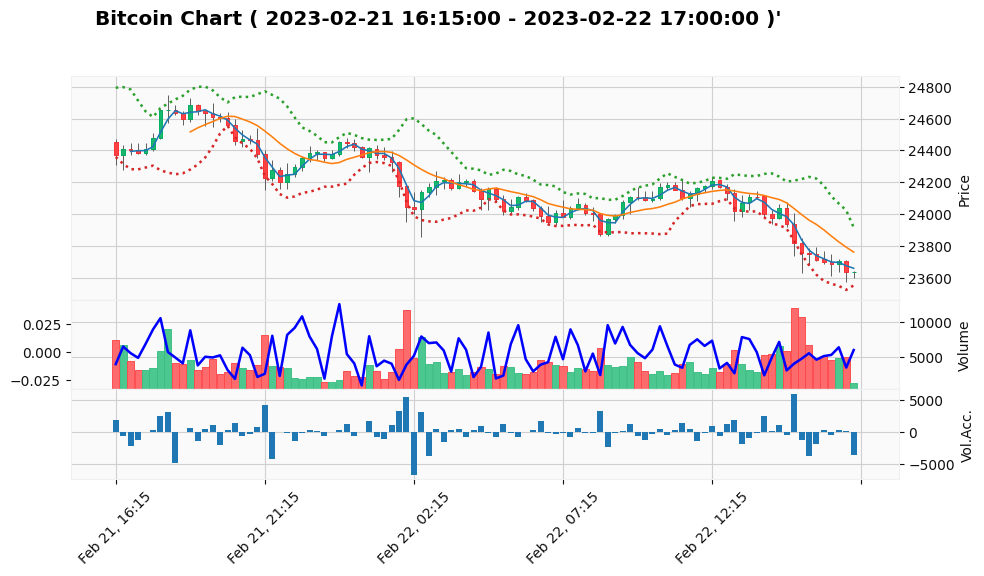

In [15]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [16]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, target = target, 
                                laststeps = 100000, step_back = 100,
                                candle_step_str = "15m",
                                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 100000 steps
Generated time-series
Normalized 'candles_norm' with shape : (100000, 10)
Feature data 'x_candles' with size : 99900
Feature data with time intervals 'x_time' with size : 99900


In [17]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.scaler
ts_btc.y[-10:]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]

## Train a CNN-LSTM model 

In [18]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, target = target, split_fraction = 0.8)

In [19]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candles (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 32)      992         ['candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 100, 32)      2272        ['candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 100, 32)      4192        ['candles[0][0]']                
                                                                                              

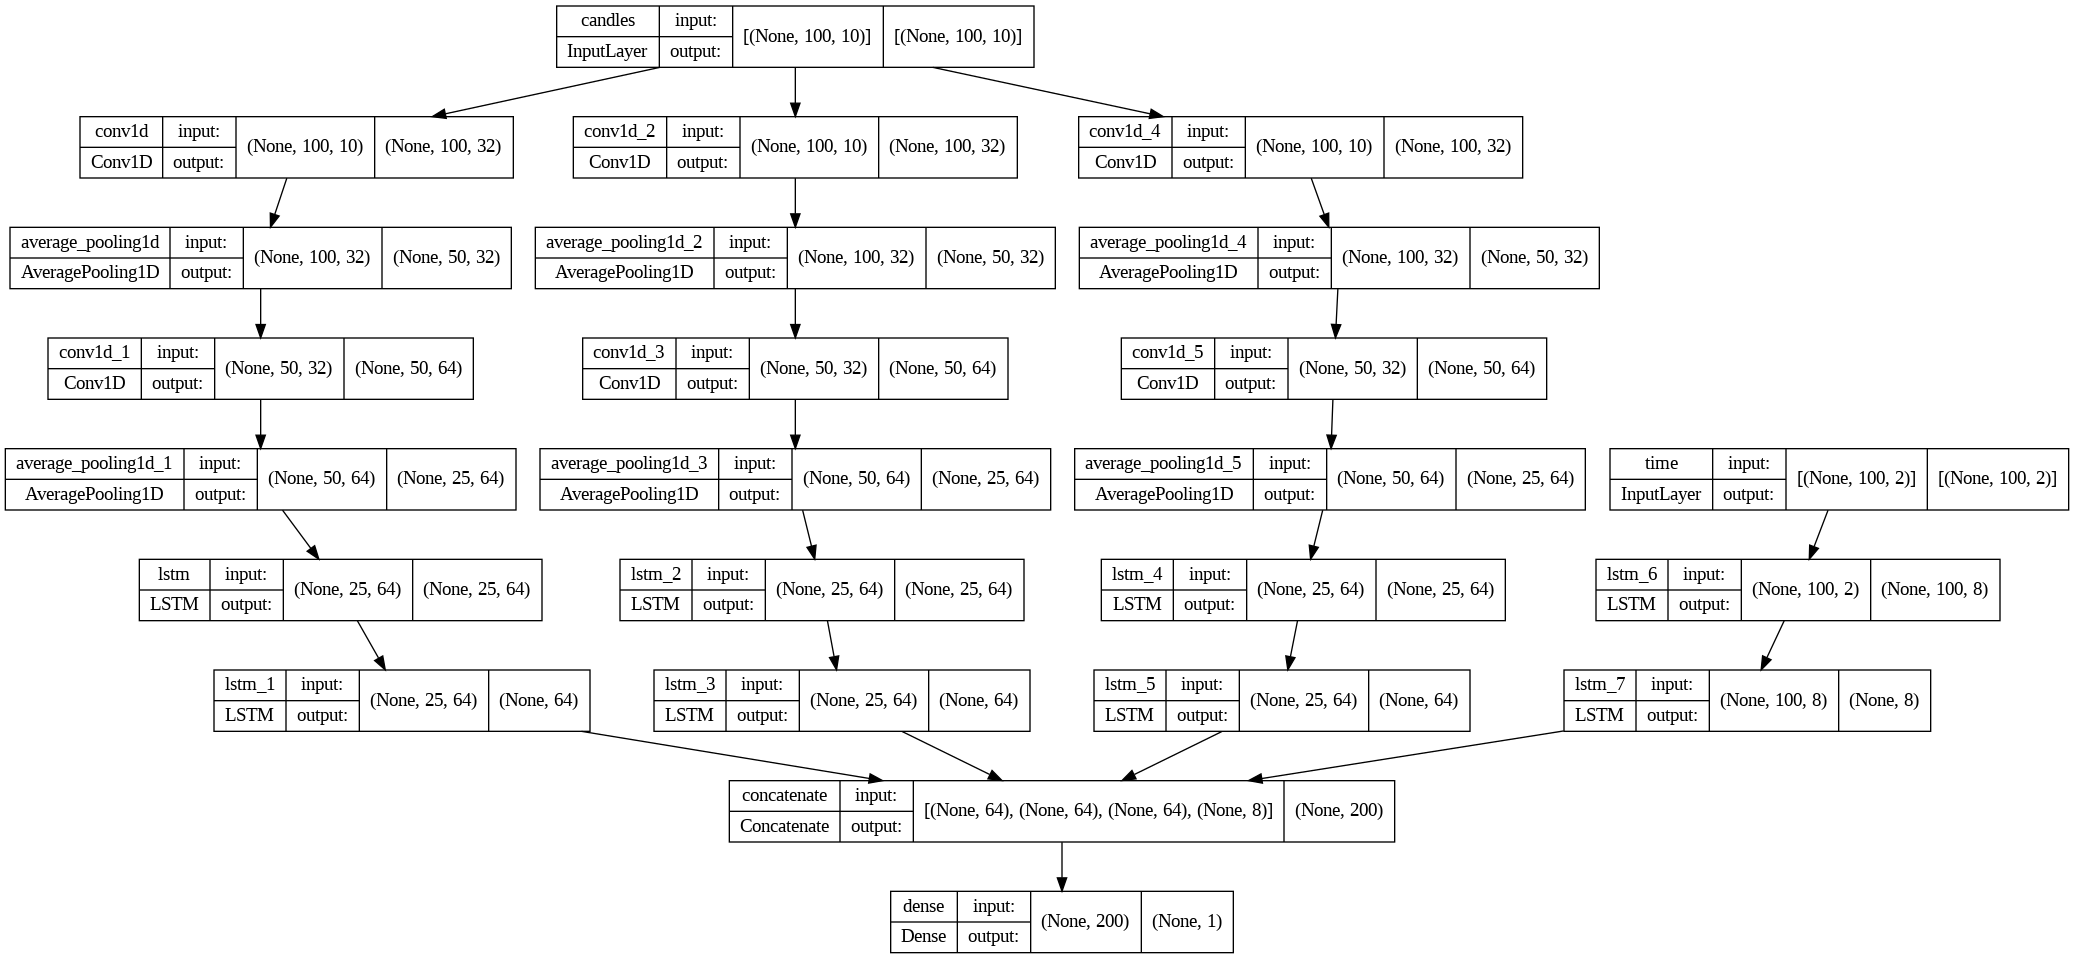

In [20]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [23]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name,save_model = False, epochs = 10)

Epoch 1/10
20/20 [==============================] - 5s 234ms/step - loss: 0.1157 - accuracy: 0.9632 - auc: 0.9941 - val_loss: 2.7902 - val_accuracy: 0.5172 - val_auc: 0.5224
Epoch 2/10
20/20 [==============================] - 5s 227ms/step - loss: 0.1347 - accuracy: 0.9538 - auc: 0.9904 - val_loss: 2.8947 - val_accuracy: 0.5156 - val_auc: 0.5219
Epoch 3/10
20/20 [==============================] - 5s 227ms/step - loss: 0.1369 - accuracy: 0.9521 - auc: 0.9900 - val_loss: 2.7623 - val_accuracy: 0.5136 - val_auc: 0.5205
Epoch 4/10
20/20 [==============================] - 5s 230ms/step - loss: 0.1235 - accuracy: 0.9586 - auc: 0.9924 - val_loss: 2.9045 - val_accuracy: 0.5139 - val_auc: 0.5193
Epoch 5/10
20/20 [==============================] - 5s 229ms/step - loss: 0.1367 - accuracy: 0.9506 - auc: 0.9898 - val_loss: 2.8945 - val_accuracy: 0.5122 - val_auc: 0.5187
Epoch 6/10
20/20 [==============================] - 5s 236ms/step - loss: 0.1140 - accuracy: 0.9626 - auc: 0.9938 - val_loss: 2.90

## Display learning curve

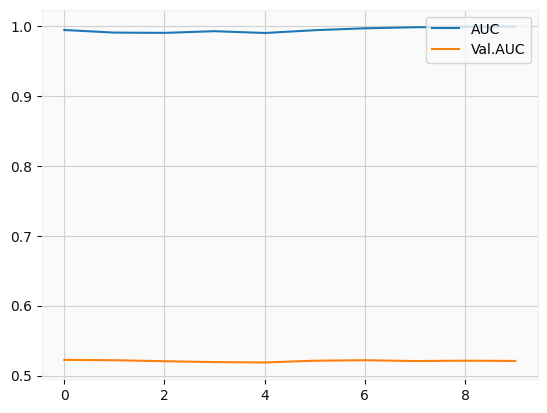

In [24]:
if target != "UpDown":
  plt.plot(btc_model.history.history['loss'], label='Loss')
  plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
else:
  plt.plot(btc_model.history.history['auc'], label='AUC')
  plt.plot(btc_model.history.history['val_auc'], label='Val.AUC')
plt.legend(loc="upper right")
plt.show()

In [25]:
btc_model.sats2pred(predict_on_test = True)

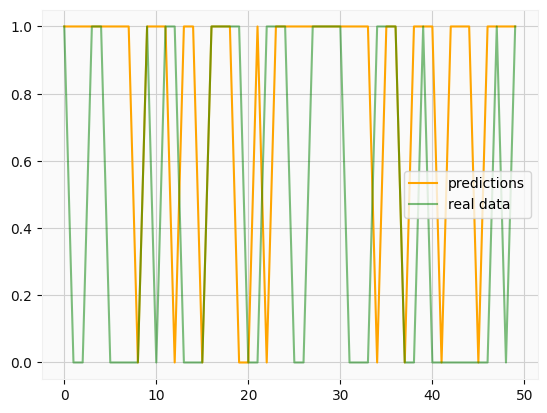

In [36]:
plot_debug = True

if plot_debug:
  plt.plot(btc_model.preds[-50:], color='orange', label='predictions')
  plt.plot(btc_model.y_test[-50:], color='green', alpha=0.5, label='real data')
  plt.legend()
  plt.show()

In [37]:
if target != "UpDown":
  true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
  preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)
else:
  true_vals = ts_btc.candles_norm[:,-1]
  preds = btc_model.preds.squeeze()

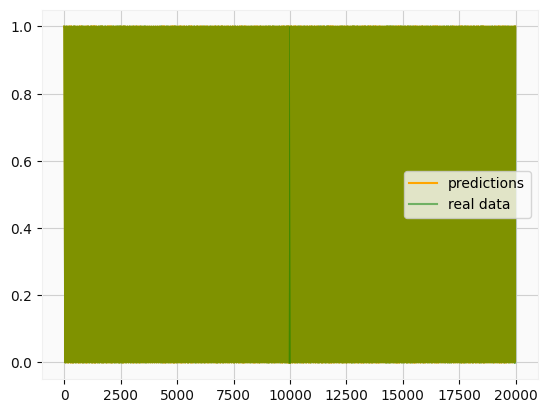

In [38]:
if plot_debug:
  plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
  plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
  plt.legend()
  plt.show()

In [29]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

In [30]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

OHLCV = ['open', 'high', 'low', 'close', 'volume']

class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [31]:
class CommInfoFractional(bt.CommissionInfo):
    """
    Allow fractions of assets/currencies
    """
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

class MLStrategy(bt.Strategy):
    params = (('n_positions', 25),
              ('min_positions', 20),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            #print(data.datetime.date(),today)
            if data.predicted[0] > 0:
                up[data._name] = data.predicted[0]
            elif data.predicted[0] < 0:
                down[data._name] = data.predicted[0]      

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
                
        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

## Back-testing 

In [32]:
from time import time

cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
# comminfo = FixedCommisionScheme()
# cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

OHLCV = ['open', 'high', 'low', 'close', 'volume']
OHLCV_cap = list(map(lambda x:x.capitalize() ,OHLCV))

if target == "Close":
  up_or_down_pred = list(map(lambda x: 1. if x> 0 else -1. ,  
                        tu.log_return(pd.Series(np.array(
                            btc_model.preds.squeeze())),periods=-1)))
  up_or_down_test = list(map(lambda x: 1. if x> 0 else -1. ,  
                             tu.log_return(pd.Series(
                                 np.array(btc_model.y_test.squeeze())),periods=-1)))
elif target == "LogReturns":
  up_or_down_pred = list(map(lambda x: 1. if x> 0 else -1. , btc_model.preds))
  up_or_down_test = list(map(lambda x: 1. if x> 0 else -1. , btc_model.y_test))
elif target == "UpDown":
  up_or_down_pred = list(map(lambda x: 1. if x> 0 else -1. , btc_model.preds.squeeze()))
  up_or_down_test = list(map(lambda x: 1. if x> 0 else -1. , btc_model.y_test))

# For backtesting we simply want to compare 
df_updown_pred =  tu.merge_true_preds(can_btc.candles,up_or_down_pred,period = -1)
df_updown_test = tu.merge_true_preds(can_btc.candles,up_or_down_test, period = -1)
df_pred_ohlcv = tu.merge_true_preds(can_btc.candles,preds,period = -1,
                              columns = OHLCV_cap).reset_index().rename(
                              columns = {i:j for i,j in zip(["Date","Pred Close"] +
                              OHLCV_cap,["date","predicted"] + OHLCV)})
                                                                                                                                        
df_pred_ohlcv["ticker"] = "BTCUSD"
df_updown_pred["ticker"] ="BTCUSD"
df_updown_test["ticker"] = "BTCUSD"      
df_updown_pred.index.name="date"
df_updown_test.index.name="date"
df_updown_test = df_updown_test.reset_index().set_index(["ticker","date"])
df_updown_pred = df_updown_pred.reset_index().set_index(["ticker","date"])

data = df_pred_ohlcv.set_index(['ticker','date'])
first_column = data.pop('predicted')
data.insert(0, 'predicted', df_updown_pred["Pred Close"])

data=data.dropna()

idx = pd.IndexSlice
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=0, 
                    verbose=True, log_file='bt_log.csv')
start = time()
# use the fractional scheme if requested
cerebro.broker.addcommissioninfo(CommInfoFractional())
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Duration: {format_time(duration)}')

Duration: 00:01:53


## Print The portfolio value

In [33]:
print(f'Initial Portfolio Value: {cash:,.2f}')
print(f'Final Portfolio Value: {ending_value:,.2f}')

Initial Portfolio Value: 10,000.00
Final Portfolio Value: 14,432.42


## Display confusion matrix

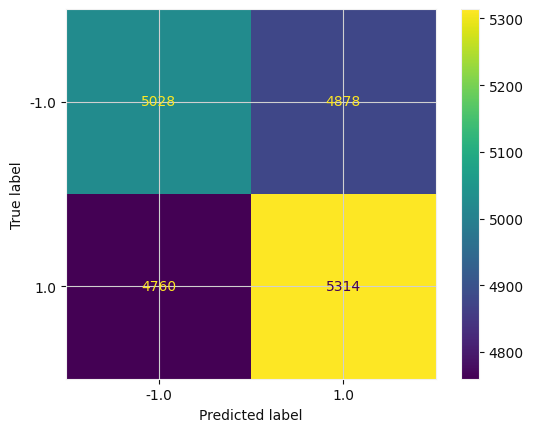

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


df_data = pd.concat([df_updown_pred.droplevel("ticker").iloc[:,-1].rename(
          "Predicted"), df_updown_test.droplevel("ticker").iloc[:,-1].rename("Test")],axis=1)

#print(confusion_matrix(df_data["Test"].dropna(), df_data["Predicted"].dropna()))

ConfusionMatrixDisplay.from_predictions( df_data["Test"].dropna(), df_data["Predicted"].dropna())

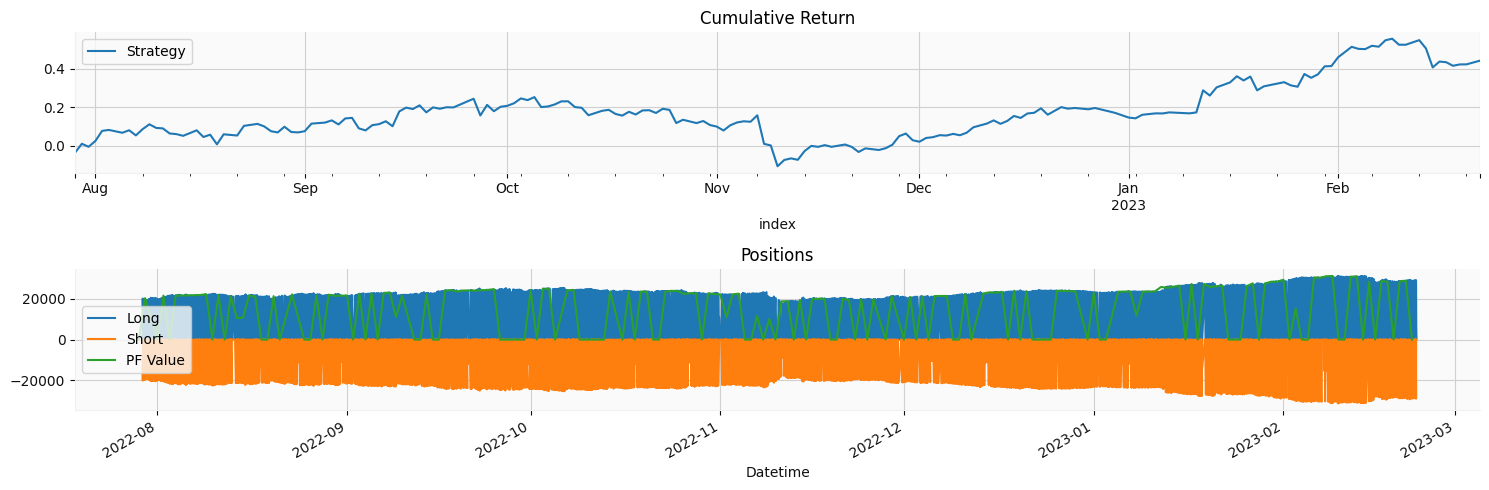

In [35]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
daily_tx = transactions.groupby(level=0)

longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

fig, axes = plt.subplots(nrows=2, figsize=(15, 5))

df = returns.to_frame('Strategy')#.join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();